In [2]:
import pandas_datareader as pdr
import numpy as np
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

In [3]:
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2021, 4, 30)
YEARS = (END - START).days/ 365.25

In [4]:
#define starting variables
STARTING_BALANCE = 10000
PCT_THRESH = 25

In [ ]:
#download data
price = pdr.get_data_yahoo('^NSEI', START, END)

price

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-09-17,4549.049805,4482.850098,4518.450195,4494.649902,0.0,4494.649902
2007-09-18,4551.799805,4481.549805,4494.100098,4546.200195,0.0,4546.200195
2007-09-19,4739.000000,4550.250000,4550.250000,4732.350098,0.0,4732.350098
2007-09-20,4760.850098,4721.149902,4734.850098,4747.549805,0.0,4747.549805
2007-09-21,4855.700195,4733.700195,4752.950195,4837.549805,0.0,4837.549805
...,...,...,...,...,...,...
2021-04-26,14557.500000,14421.299805,14449.450195,14485.000000,452700.0,14485.000000
2021-04-27,14667.549805,14484.849609,14493.799805,14653.049805,451800.0,14653.049805
2021-04-28,14890.250000,14694.950195,14710.500000,14864.549805,457000.0,14864.549805


In [ ]:
#drop redundant columns
price = price.drop(['Volume', 'Adj Close'], 1)

price.tail()

,High,Low,Open,Close
Date,,,,
2021-04-26,14557.500000,14421.299805,14449.450195,14485.000000
2021-04-27,14667.549805,14484.849609,14493.799805,14653.049805
2021-04-28,14890.250000,14694.950195,14710.500000,14864.549805
2021-04-29,15044.349609,14814.450195,14979.000000,14894.900391
2021-04-30,14855.450195,14601.700195,14747.349609,14631.099609


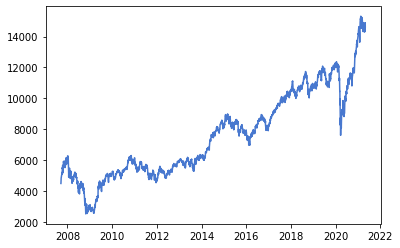

In [ ]:
#plot chart
plt.style.use('seaborn-muted')
plt.plot(price.Close)
plt.show()

In [ ]:
#calculate benchmark return and balance
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

In [ ]:
#calculate benchmark drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
price.head()

,High,Low,Open,Close,Return,Bench_Bal,Bench_Peak,Bench_DD
Date,,,,,,,,
2007-09-17,4549.049805,4482.850098,4518.450195,4494.649902,1.000000,10000.000000,10000.000000,0.0
2007-09-18,4551.799805,4481.549805,4494.100098,4546.200195,1.011469,10114.692566,10114.692566,0.0
2007-09-19,4739.000000,4550.250000,4550.250000,4732.350098,1.040946,10528.851413,10528.851413,0.0
2007-09-20,4760.850098,4721.149902,4734.850098,4747.549805,1.003212,10562.668746,10562.668746,0.0
2007-09-21,4855.700195,4733.700195,4752.950195,4837.549805,1.018957,10762.906811,10762.906811,0.0


In [ ]:
bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)

bench_dd


-59.86

In [ ]:
#calculate additional columns for strategy

#daily range
price['Range'] = price.High - price.Low
#distance between close and daily low
price['Dist'] = abs(price.Close - price.Low)
#distance as % of range
price['Pct'] = (price.Dist / price.Range) * 100

price.tail()

,High,Low,Open,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct
Date,,,,,,,,,,,
2021-04-26,14557.500000,14421.299805,14449.450195,14485.000000,1.010017,32227.204153,34073.177062,-1845.972909,136.200195,63.700195,46.769533
2021-04-27,14667.549805,14484.849609,14493.799805,14653.049805,1.011602,32601.092684,34073.177062,-1472.084378,182.700195,168.200195,92.063501
2021-04-28,14890.250000,14694.950195,14710.500000,14864.549805,1.014434,33071.652137,34073.177062,-1001.524925,195.299805,169.599609,86.840645
2021-04-29,15044.349609,14814.450195,14979.000000,14894.900391,1.002042,33139.178166,34073.177062,-933.998896,229.899414,80.450195,34.993650
2021-04-30,14855.450195,14601.700195,14747.349609,14631.099609,0.982289,32552.256410,34073.177062,-1520.920652,253.750000,29.399414,11.585976


"If close at high Pct = 100 and if close at low Pct = 0"

In [ ]:
#identify entries and allocate trading fees
price['Long'] = price.Pct < PCT_THRESH


In [ ]:
#calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())

price.head()

,High,Low,Open,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal
Date,,,,,,,,,,,,,,
2007-09-17,4549.049805,4482.850098,4518.450195,4494.649902,1.000000,10000.000000,10000.000000,0.0,66.199707,11.799805,17.824557,True,1.000000,10000.000000
2007-09-18,4551.799805,4481.549805,4494.100098,4546.200195,1.011469,10114.692566,10114.692566,0.0,70.250000,64.650391,92.029026,False,1.011469,10114.692566
2007-09-19,4739.000000,4550.250000,4550.250000,4732.350098,1.040946,10528.851413,10528.851413,0.0,188.750000,182.100098,96.476873,False,1.000000,10114.692566
2007-09-20,4760.850098,4721.149902,4734.850098,4747.549805,1.003212,10562.668746,10562.668746,0.0,39.700195,26.399902,66.498167,False,1.000000,10114.692566
2007-09-21,4855.700195,4733.700195,4752.950195,4837.549805,1.018957,10762.906811,10762.906811,0.0,122.000000,103.849609,85.122631,False,1.000000,10114.692566


In [ ]:
price['Sys_Bal_Cost'] = np.where(price['Long'].shift(1)==True,price['Sys_Bal']-(price['Sys_Bal']*0.001),price['Sys_Bal'])
price.head()


,High,Low,Open,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal,Sys_Bal_Cost
Date,,,,,,,,,,,,,,,
2007-09-17,4549.049805,4482.850098,4518.450195,4494.649902,1.000000,10000.000000,10000.000000,0.0,66.199707,11.799805,17.824557,True,1.000000,10000.000000,10000.000000
2007-09-18,4551.799805,4481.549805,4494.100098,4546.200195,1.011469,10114.692566,10114.692566,0.0,70.250000,64.650391,92.029026,False,1.011469,10114.692566,10104.577873
2007-09-19,4739.000000,4550.250000,4550.250000,4732.350098,1.040946,10528.851413,10528.851413,0.0,188.750000,182.100098,96.476873,False,1.000000,10114.692566,10114.692566
2007-09-20,4760.850098,4721.149902,4734.850098,4747.549805,1.003212,10562.668746,10562.668746,0.0,39.700195,26.399902,66.498167,False,1.000000,10114.692566,10114.692566
2007-09-21,4855.700195,4733.700195,4752.950195,4837.549805,1.018957,10762.906811,10762.906811,0.0,122.000000,103.849609,85.122631,False,1.000000,10114.692566,10114.692566


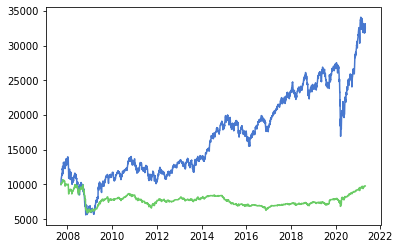

In [ ]:
#plot balance
plt.plot(price.Bench_Bal)
plt.plot(price.Sys_Bal_Cost)

plt.show()


In [ ]:
#calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal_Cost.cummax()
price['Sys_DD'] = price.Sys_Bal_Cost - price.Sys_Peak
price.head()

,High,Low,Open,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal,Sys_Bal_Cost,Sys_Peak,Sys_DD
Date,,,,,,,,,,,,,,,,,
2007-09-17,4549.049805,4482.850098,4518.450195,4494.649902,1.000000,10000.000000,10000.000000,0.0,66.199707,11.799805,17.824557,True,1.000000,10000.000000,10000.000000,10000.000000,0.0
2007-09-18,4551.799805,4481.549805,4494.100098,4546.200195,1.011469,10114.692566,10114.692566,0.0,70.250000,64.650391,92.029026,False,1.011469,10114.692566,10104.577873,10104.577873,0.0
2007-09-19,4739.000000,4550.250000,4550.250000,4732.350098,1.040946,10528.851413,10528.851413,0.0,188.750000,182.100098,96.476873,False,1.000000,10114.692566,10114.692566,10114.692566,0.0
2007-09-20,4760.850098,4721.149902,4734.850098,4747.549805,1.003212,10562.668746,10562.668746,0.0,39.700195,26.399902,66.498167,False,1.000000,10114.692566,10114.692566,10114.692566,0.0
2007-09-21,4855.700195,4733.700195,4752.950195,4837.549805,1.018957,10762.906811,10762.906811,0.0,122.000000,103.849609,85.122631,False,1.000000,10114.692566,10114.692566,10114.692566,0.0


In [ ]:

sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

sys_dd

-44.77

In [ ]:
#calculate metrics
bench_return = round(((price.Bench_Bal[-1]/price.Bench_Bal[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
sys_return = round(((price.Sys_Bal_Cost[-1]/price.Sys_Bal_Cost[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal_Cost[-1]/price.Sys_Bal_Cost[0])**(1/YEARS))-1)*100), 2)
sys_in_market = round((price.Long.value_counts().loc[True] / len(price)) * 100)
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'Winrate: {sys_winrate}%')


Benchmark Total return: 225.52%
Benchmark CAGR: 5.69
Benchmark DD: -59.86%

System Total return: -2.16%
System CAGR: -0.1
System DD: -44.77%
Time in Market: 28%
Trades Won: 466
Trades Loss: 454
Winrate: 50.65%


In [5]:
symbols = ['^NSEBANK', '^NSEI', '^GSPC', 'RELIANCE.NS', '^N225']

In [13]:
#create backtesting function
def backtest(symbol, PCT_THR=20):
    #download data
    price = pdr.get_data_yahoo(symbol, START, END)
    
    #drop redundant columns
    price = price.drop(['Volume', 'Adj Close'], 1)
    
    #calculate benchmark return and balance
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    
    #calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
    
    #calculate additional columns for strategy
    #daily range
    price['Range'] = price.High - price.Low
    #distance between close and daily low
    price['Dist'] = abs(price.Close - price.Low)
    #distance as % of range
    price['Pct'] = (price.Dist / price.Range) * 100
    
    #identify entries and allocate trading fees
    price['Long'] = price.Pct < PCT_THR
    
    #calculate system return and balance
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())
    
    #calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal.cummax()
    price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak
    
    #calculate metrics
    bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_cagr = round(((((price.Sys_Bal[-1]/price.Sys_Bal[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)
    
    return bench_cagr, sys_cagr

In [14]:
#backtest multiple symbols
bc = []
sc = []


for symbol in symbols:
    bench_cagr, sys_cagr = backtest(symbol)
    bc.append(bench_cagr)
    sc.append(sys_cagr)

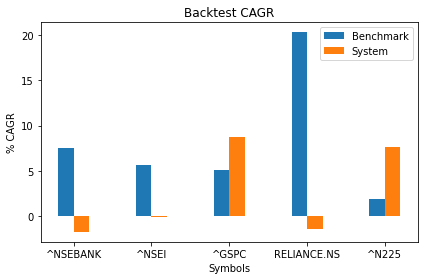

In [15]:
#plot data
x_indices = np.arange(len(symbols))
width = 0.2

plt.bar(x_indices - width / 2, bc, width = width, label = 'Benchmark')
plt.bar(x_indices + width / 2, sc, width = width, label = 'System')
   
plt.xticks(ticks = x_indices, labels = symbols)

plt.legend()

plt.title('Backtest CAGR')
plt.xlabel('Symbols')
plt.ylabel('% CAGR')
plt.tight_layout()

plt.show()